# Patch Match

This algorithm is designed to fill a hole in a picture. It is inspired from:
- Criminisi, A., Pérez, P., & Toyama, K. (2004). Region filling and object removal by exemplar-based image inpainting. IEEE Transactions on image processing, 13(9), 1200-1212.
- Kwatra, V., Schödl, A., Essa, I., Turk, G., & Bobick, A. (2003, July). Graphcut textures: image and video synthesis using graph cuts. In ACM Transactions on Graphics (ToG) (Vol. 22, No. 3, pp. 277-286). ACM.

In [1]:
import numpy as np
np.random.seed(42)
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.misc import face
from scipy.linalg import norm
from skimage import measure
import skimage
from scipy.ndimage import filters as fi
import networkx as nx
from sklearn import cluster
import multiprocessing
from multiprocessing import JoinableQueue as Queue
import time
import cv2
import os 
%matplotlib inline

In [2]:
#Define the minimum and maximum size of applied patch
psi_min = 22
psi_max = 29

#Define the size of the neighborhood in which the algorithm will search
search_area_size = 100

#If True, this code use several cores. WARNING, maybe false ! 
multi_processing = False # [Errno 32] Broken pipe if true, not sure why

#If True, the algorithm will also try rotated patch
rotation = False

#Define where the hole in the image will be
hole_left_corner_original_x = 100
hole_left_corner_original_y = 50
hole_width = 50
hole_height = 50
hole_left_marged_x = hole_left_corner_original_x + psi_max
hole_right_marged_x = hole_left_corner_original_x + psi_max + hole_width
hole_top_marged_y = hole_left_corner_original_y + psi_max
hole_bottom_marged_y = hole_left_corner_original_y + psi_max + hole_height

In [3]:
if rotation:
    r_max = 4
else:
    r_max = 1

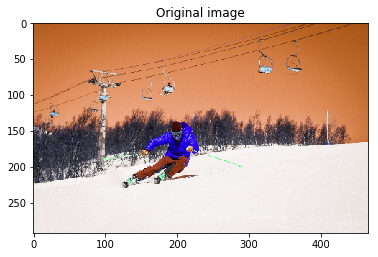

The dim of the image is (292L, 466L, 3L)


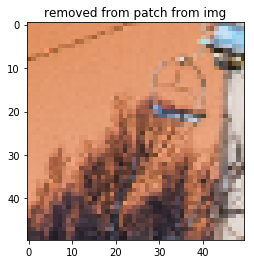

The dim of the image is (50L, 50L, 3L)


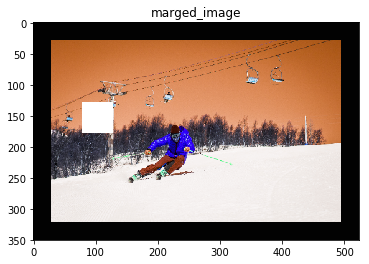

The dim of the image is (350L, 524L, 3L)


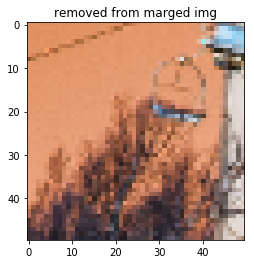

The dim of the image is (50L, 50L, 3L)


In [4]:
#Initialisation of pictures

#open the picture
imgpath = "../ressources/ski.png"

#img = np.load(imgpath)
img = cv2.imread(imgpath)
#img = face()

#Plot the Initial Picture
img.reshape((img.shape[0], img.shape[1], -1))
plt.imshow(img, interpolation='none', norm=Normalize(vmin=0, vmax=255))
plt.title("Original image")
plt.show()
print 'The dim of the image is ' + str(img.shape)
shape = img.shape[2]

#Print the removed part
removed_patch = img[hole_left_corner_original_x:hole_left_corner_original_x+hole_width, hole_left_corner_original_y:hole_left_corner_original_y+hole_height].copy().astype(np.uint8)
plt.imshow(removed_patch)
plt.title("removed patch from img")
plt.show()
print 'The dim of the image is ' + str(removed_patch.shape)

# Create the black margin around the image with size pf psi_max on each edge
marged_img = (np.zeros((img.shape[0] + 2 * psi_max, img.shape[1] + 2 * psi_max, shape)) + 2).astype(int)
marged_img[psi_max: - psi_max, psi_max:-psi_max] = img.astype(int).copy()

#Print the removed part
removed_part_from_marged = marged_img[hole_left_marged_x:hole_right_marged_x, hole_top_marged_y:hole_bottom_marged_y].copy().astype(np.uint8)

#Create a hole
#marged_img[(marged_img[:,:,0]==0) * (marged_img[:,:,1]==0) * (marged_img[:,:,2]==0)] = - np.ones(shape)
marged_img[hole_left_marged_x:hole_right_marged_x, hole_top_marged_y:hole_bottom_marged_y] = - np.ones(shape) # fron [x1:x2, y1:y2]

#Plot the holed picture
plt.imshow(marged_img.astype(np.uint8), interpolation='none', norm=Normalize(vmin=0, vmax=255))
plt.title("marged_image")
plt.show()
print 'The dim of the image is ' + str(marged_img.shape)


plt.imshow(removed_part_from_marged)
plt.title("removed patch from marged img")
plt.show()
print 'The dim of the image is ' + str(removed_part_from_marged.shape)
# width_face = 914px = 768px (original) + 2* 73px (psi_max)

In [5]:
#Needed variables

#Create the confidence matrix
confidence = np.ones((marged_img.shape[0], marged_img.shape[1]))
confidence[marged_img[:,:,0] == -1]=0
confidence[(marged_img[:,:,0] == 2) * (marged_img[:,:,1] == 2) * (marged_img[:,:,2] == 2)]=0

In [6]:
#All needed functions

#find priority term
def confidence_coefficient(confidence, pt, psi=9):
    result = 0
    for i in range(psi):
        for j in range(psi):
            result += confidence[np.int(pt[0] + i - (psi-1)/2+0.5), np.int(pt[1] + j - (psi-1)/2 +0.5)]
    return float(result)/psi**2

#Normal vector to the contour
def gen_normal_vector(omega):
    tangeantes = [(omega[i+1][0] - omega[i-1][0],omega[i+1][1] - omega[i-1][1]) for i in range(1, len(omega)-1)]
    normals = [(-j/np.sqrt(i*i+j*j), i/np.sqrt(i*i+j*j)) for i,j in tangeantes]
    return normals 

#Creation of the data coefficient
def gen_data_vector(normal, isophote, alpha=255.):
    result = [np.abs(normal[i][0] * isophote[i][0] + normal[i][1] * isophote[i][1])/alpha for i in range(len(isophote))]
    return result

#Create a 3d norm
def norm3d(img, param):
    temp = img.reshape((img.shape[0], img.shape[1], -1))
    shape = temp.shape[2]
    result = 0
    for i in range(shape):
        result += norm(img[:, :, i], param)
    return result

#Create a distance which takes into account the distance to a hole
def distance(img1, img2, is_compared, gauss, param = 2):
    temp = img1.reshape((img1.shape[0], img1.shape[1], -1))
    shape = temp.shape[2]
    result = 0

    for i in range(shape):
        result += norm((img1[:, :, i] - img2[:, :, i]) * gauss, param)
    return result

# Compute the distance for a given center
def create_kernel_local(xc, yc):
    result = np.zeros((psi, psi))
    for i in range(psi):
        for j in range(psi):
            result[i,j] = float((i-xc)**2 + (j-yc)**2) / 2
    m = np.max(result)        
    result = 1 - result.astype(np.float) / m
    return result

#Compute distance for a whole hole
def create_kernel_patch(is_compared):
    result = np.zeros(is_compared.shape)
    counter = 0
    for i in range(is_compared.shape[0]):
        for j in range(is_compared.shape[1]):
            if is_compared[i,j] == 0:
                result += create_kernel_local(i, j)
                counter += 1
    result = result.astype(np.float) / counter
    return result

#Find best match with one core
def findbestmatch(patch, img, is_compared, patch_x, patch_y, psi=9):
    result = 9999
    gauss = create_kernel_patch(is_compared[:, :, 0])
    counter = 0
    for i in range(max(0, int(patch_x - search_area_size)), int(patch_x + search_area_size + 1)):
            for j in range(max(0, int(patch_y - search_area_size)), int(patch_y + search_area_size + 1)):
                for r in range(r_max):
                    counter +=1
                    if counter % 50000 == 0:
                        print("Counter %s"%counter)
                    patch_comp = patch * is_compared
                    if (i<psi/2) | (j<psi/2) | (i>img.shape[0]-psi/2-1) | (j>img.shape[1]-psi/2-1):
                        pass
                    else:
                        img_comp = img[i - psi/2: i + psi/2+1, j - psi/2: j + psi/2+1].copy()
                        img_comp = np.rot90(img_comp, r)
                        if np.all(img_comp[:, :, 0] != -1):
                            img_comp *= is_compared
                            #print(img_comp.shape)
                            if distance(img_comp, patch_comp, is_compared[:, :, 0], gauss) < result:
                                result = distance(img_comp, patch_comp, is_compared[:, :, 0], gauss)
                                result_x = i
                                result_y = j
                                result_r = r
    return result_x, result_y, result_r

#Find the right contour in the picture
def find_good_contour(contours, img):
    for contour in contours:
        pt = contour[len(contour)/2]
        pt = [int(i) for i in pt]
        if np.any(img[pt[0]-1:pt[0]+2, pt[1]-1:pt[1]+2]==[-1,-1,-1]) :
            contour = np.concatenate((np.array([contour[0]]), contour, np.array([contour[-1]])))
            contour = contour+0.5
            return True, contour
    return False, []

#Find the maximal value in temp
def pooling(temp):
    return np.max(np.abs(temp))

#Compute the gradient of a patch with a hole in it
def get_isophote(pts, img, psi=9):
    isophote = []
    for pt in pts:
        x = pt[0]
        y = pt[1]
        temp = img[np.int(x - psi/2): np.int(x + psi/2+1), np.int(y - psi/2): np.int(y + psi/2+1)]
        grad = np.gradient(np.ma.masked_where(temp == -1, temp))
        isophote.append((pooling(grad[0]), pooling(grad[1])))
    return isophote

#Small usefull function
def should_be_connected(n1, n2):
    if (len(n1) == 2) & (len(n2) == 2):
        return( ((n1[0]-n2[0])**2 + (n1[1]-n2[1])**2) == 1 )
    else:
        raise NameError("Wrong node")

#Compute the term to term addition of two tuples
def tuple_add(pt1, pt2):
    return (int(pt1[0] + pt2[0]), int(pt1[1] + pt2[1]))

#Compute the term to term difference of two tuples
def tuple_minus(pt1, pt2):
    return (pt1[0] - pt2[0], pt1[1] - pt2[1])

#Compute the weight of an edge
def edge_weight(pt1_ini, pt2_ini, old_patch, new_patch, demi=False):   
    if demi:
        diff = tuple_minus(pt2_ini, pt1_ini)

        pt1 = (int(pt1_ini[0]), int(pt1_ini[1]))
        pt2 = tuple_add(pt2_ini, diff)
    else:
        pt1 = (int(pt1_ini[0]), int(pt1_ini[1]))
        pt2 = (int(pt2_ini[0]), int(pt2_ini[1]))
    
    return (norm3d(old_patch[pt1].reshape((1, 1, -1))-new_patch[pt1].reshape((1, 1, -1)), 2) + 
        norm3d(old_patch[pt2].reshape((1, 1, -1))-new_patch[pt2].reshape((1, 1, -1)), 2))
        
#Transform a tuple into a tuple of integers
def tuple_in(t, l):
    return (t in l) | ((t[1], t[0]) in l)

#Transform the patch probleme into a graph
def create_graph(img_ini, pt_ini, new_patch, cut_edges, psi=9):
    img = img_ini.reshape((img_ini.shape[0], img_ini.shape[1], -1))
    pt = (int(pt_ini[0] + 0.5), int(pt_ini[1] + 0.5))
    old_patch = img[pt[0] - psi/2 - 1: pt[0] + psi/2 + 2, pt[1] - psi/2 - 1: pt[1] + psi/2 + 2]
    G=nx.Graph()
    G.add_node("old")
    G.add_node("new")
    for i in range(pt[0] - psi/2, pt[0] + psi/2+1):
        firsti = (i == pt[0] - psi/2)
        lasti = (i == pt[0] + psi/2)
        for j in range(pt[1] - psi/2, pt[1] + psi/2+1):
            firstj = (j == pt[1] - psi/2)
            lastj = (j == pt[1] + psi/2)
            if img[i, j, 0] != -1:
                G.add_node((i, j))
                if not firsti:
                    if ((img[i-1, j, 0] == -1) & ((i-1, j) not in G.nodes())):
                        G.add_node((i-1, j))
                        G.add_edge((i-1, j), 'new', weight=np.inf)
                else:
                    G.add_node((i-1, j))
                    G.add_edge((i-1, j), 'old', weight=np.inf)
                if not lasti:
                    if ((img[i+1, j, 0] == -1) & ((i+1, j) not in G.nodes())):
                        G.add_node((i+1, j))
                        G.add_edge((i+1, j), 'new', weight=np.inf)
                else:
                    G.add_node((i+1, j))
                    G.add_edge((i+1, j), 'old', weight=np.inf)
                if not firstj:
                    if ((img[i, j-1, 0] == -1) & ((i, j-1) not in G.nodes())):
                        G.add_node((i, j-1))
                        G.add_edge((i, j-1), 'new', weight=np.inf)
                else:
                    G.add_node((i, j-1))
                    G.add_edge((i, j-1), 'old', weight=np.inf)
                if not lastj:
                    if ((img[i, j+1, 0] == -1) & ((i, j+1) not in G.nodes())):
                        G.add_node((i, j+1))
                        G.add_edge((i, j+1), 'new', weight=np.inf)
                else:
                    G.add_node((i, j+1))
                    G.add_edge((i, j+1), 'old', weight=np.inf)
                    
                for ibis, jbis in [(i-1, j), (i+1,j), (i, j-1), (i, j+1)]:
                    if (not tuple_in(((i,j), (ibis, jbis)), G.edges())) & ((ibis,jbis) in G.nodes()):
                        if ((i,j), (ibis, jbis)) in cut_edges:
                            idemi, jdemi = (float(i+ibis)/2, float(j+jbis)/2)
                            G.add_node((idemi, jdemi))
                            G.add_edge((idemi,jdemi), 'new', attr_dict=cut_edges)
                            G.add_edge((i, j), (idemi, jdemi), weight=edge_weight((i - pt[0] + psi/2 + 1, j - pt[1] + psi/2 + 1), 
                                                                 (idemi - pt[0] + psi/2 + 1, jdemi - pt[1] + psi/2 + 1),
                                                                 old_patch, new_patch, demi=True))
                            G.add_edge((ibis, jbis), (idemi, jdemi), weight=edge_weight((ibis - pt[0] + psi/2 + 1, jbis - pt[1] + psi/2 + 1), 
                                                                 (idemi - pt[0] + psi/2 + 1, jdemi - pt[1] + psi/2 + 1),
                                                                 old_patch, new_patch, demi=True))
                        else:
                            G.add_edge((ibis, jbis), (i,j), weight=edge_weight((i - pt[0] + psi/2 + 1, j - pt[1] + psi/2 + 1), 
                                                                     (ibis - pt[0] + psi/2 + 1, jbis - pt[1] + psi/2 + 1),
                                                                     old_patch, new_patch))
    return G

#Find edge which have been cut
def find_cut_edges(G, set_old, dico_cut_edges):
    list_just_cut = []
    for edge in G.edges(data=True):
        node1 = edge[0]
        node2 = edge[1]
        if (node1!='old') & (node1!='new') & (node2!='old') & (node2!='new'):
            if ((node1 in set_old) & (node2 not in set_old)) | ((node1 not in set_old) & (node2 in set_old)):
                if np.floor(node1[0]) != node1[0]:
                    node1 = (2 * node1[0] - node2[0], node1[1])
                elif np.floor(node1[1]) != node1[1]:
                    node1 = (node1[0], 2 * node1[1] - node2[1])
                elif np.floor(node2[0]) != node2[0]:
                    node2 = (2 * node2[0] - node1[0], node2[1])
                elif np.floor(node2[1]) != node2[1]:
                    node2 = (node2[0], 2 * node2[1] - node1[1])
                dico_cut_edges[(node1, node2)]= edge[2]["weight"]
                dico_cut_edges[(node2, node1)]= edge[2]["weight"]
                list_just_cut.append((node1, node2))
    return dico_cut_edges, list_just_cut

#Remove deleted edges
def update_cut_edges(cut_edges, new_set):
    new_cut_edges = {}
    for edge in cut_edges:
        node1 = edge[0]
        node2 = edge[1]
        if (node1 not in new_set) | (node2 not in new_set):
            new_cut_edges[edge]= cut_edges[edge]
    return new_cut_edges

#Mix two patches without blur
def clean_mix(old_patch, new_patch, set_old, patch_x, patch_y, psi):
    applied_patch = new_patch.copy()
    for pt in set_old:
        if (pt!='old'):
            if (np.int(pt[0] - patch_x + psi/2)>=0) & (np.int(pt[0] - patch_x + psi/2)<psi) & \
                (np.int(pt[1] - patch_y + psi/2)>=0) & (np.int(pt[1] - patch_y + psi/2)<psi):
                applied_patch[np.int(pt[0] - patch_x + psi/2), np.int(pt[1] - patch_y + psi/2)] = \
                                old_patch[np.int(pt[0] - patch_x + psi/2 ), np.int(pt[1] - patch_y + psi/2 )]
    return applied_patch

#Mix two patches with blur
def blur_mix(img_ini, new_patch, enlarged_new_patch, set_old, just_cut_edges, patch_x, patch_y, psi):
    img = img_ini.reshape((img_ini.shape[0], img_ini.shape[1], -1))
    pt = (int(patch_x + 0.5), int(patch_y + 0.5))
    old_patch = img[pt[0] - psi/2: pt[0] + psi/2 + 1, pt[1] - psi/2: pt[1] + psi/2 + 1]
    enlarged_old_patch = img[pt[0] - psi/2 - 1: pt[0] + psi/2 + 2, pt[1] - psi/2 - 1: pt[1] + psi/2 + 2]
    applied_patch = img[pt[0] - psi/2 - 1: pt[0] + psi/2 + 2, pt[1] - psi/2 - 1: pt[1] + psi/2 + 2]
    applied_patch[1:-1, 1:-1] = clean_mix(old_patch, new_patch, set_old, patch_x, patch_y, psi)
    for edge in just_cut_edges:
        node1 = edge[0]
        node2 = edge[1]
        value11, value12 = np.int(node1[0] - patch_x + psi/2 + 1), np.int(node1[1] - patch_y + psi/2 + 1)
        value21, value22 = np.int(node2[0] - patch_x + psi/2 + 1), np.int(node2[1] - patch_y + psi/2 + 1)
        if node1 in set_old:
            applied_patch[value11, value12] = 0.66 * enlarged_old_patch[value11, value12] + 0.34 * enlarged_new_patch[value11, value12]
            applied_patch[value21, value22] = 0.34 * enlarged_old_patch[value21, value22] + 0.66 * enlarged_new_patch[value21, value22]
        else:
            applied_patch[value11, value12] = 0.34 * enlarged_old_patch[value11, value12] + 0.66 * enlarged_new_patch[value11, value12]
            applied_patch[value21, value22] = 0.66 * enlarged_old_patch[value21, value22] + 0.34 * enlarged_new_patch[value21, value22]
    return applied_patch[1:-1, 1:-1]

In [7]:
class Worker_process(multiprocessing.Process):
    """
    Define a custon worker with two more attributes
    """

    def __init__(self, args=()):
        multiprocessing.Process.__init__(self)
        self.args = args
        self.result = (0, 0, 0)
        self.distance = 99999

    def run(self):
        queue, result_queue, img, is_compared, gauss, patch, psi, verbose = self.args
        self.worker_function(queue, result_queue, img, is_compared, gauss, patch, psi, verbose)
        return

    def worker_function(self, queue, result_queue, img, is_compared, gauss, patch, psi, verbose=True):
        """
        While the queue with all works is not empty, the worker will take the last element, Compute
        the calcul and store this element if the distance to the patch is the smallest he found.
        """
        patch_comp = patch * is_compared
        while True:
            if queue.empty():
                break
            try:
                i, j, r = queue.get(True, 1)
            except multiprocessing.queues.Empty:
                print("Caught")
                break
            if (i<psi/2) | (j<psi/2) | (i>img.shape[0]-psi/2-1) | (j>img.shape[1]-psi/2-1):
                queue.task_done()
            else:
                img_comp = img[i - psi/2: i + psi/2+1, j - psi/2: j + psi/2+1].copy()
                img_comp = np.rot90(img_comp, r)
                if np.all(img_comp[:, :, 0] != -1):
                    img_comp *= is_compared
                    #print(img_comp.shape)
                    if distance(img_comp, patch_comp, is_compared[:, :, 0], gauss) < self.distance:
                        self.distance = distance(img_comp, patch_comp, is_compared[:, :, 0], gauss)
                        self.result = (i, j, r)
                    #result_queue.put(((i,j), distance(img_comp, patch_comp, is_compared[:, :, 0], gauss)))
                queue.task_done()
        result_queue.put((self.distance, self.result))
        return

def create_queue(main_queue, patch_x, patch_y, min_i=0):
    """
    Create the queue with all centers of patch we have to examine
    """
    for i in range(max(min_i, int(patch_x - search_area_size)), int(patch_x + search_area_size + 1)):
        for j in range(max(0, int(patch_y - search_area_size)), int(patch_y + search_area_size + 1)):
            for r in range(r_max):
                if main_queue.full():
                    return i
                main_queue.put((i, j, r))

def get_result(result_queue):
    """
    Return the result with the lowest distance
    """
    distance, result_xyr = result_queue.get()
    while not(result_queue.empty()):
        distance_temp, result_xyr_temp = result_queue.get()
        if distance_temp < distance:
            result_xyr = result_xyr_temp
            distance = distance_temp
    return result_xyr

#Master function
def findbestmatchmultiprocess(patch, img, is_compared, patch_x, patch_y, psi=9, verbose=True, n_processes=None):
    """
    Find the best match with multi processing.
    """

    main_queue = Queue() 
    lasti = create_queue(main_queue, patch_x, patch_y)
    result_queue = Queue()

    if n_processes is None:
        num_processes = multiprocessing.cpu_count()
    else:
        num_processes = n_processes
    gauss = create_kernel_patch(is_compared[:, :, 0])

    jobs = []
    for i in range(num_processes):
        p = Worker_process(args=(main_queue, result_queue, img, is_compared, gauss, patch, psi, verbose))
        jobs.append(p)
        p.start()
    
    create_queue(main_queue, patch_x, patch_y, lasti)

    if verbose:
        print '*** Main thread waiting'

    for job in jobs:
        job.join()

    if verbose:
        print '*** Done'

    time.sleep(1)

    return get_result(result_queue)

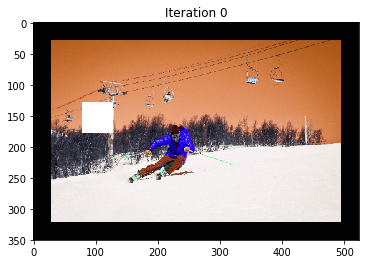

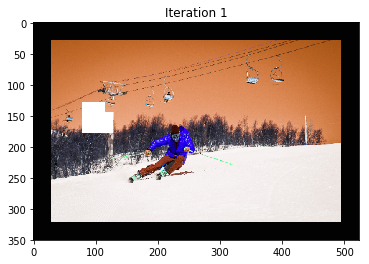

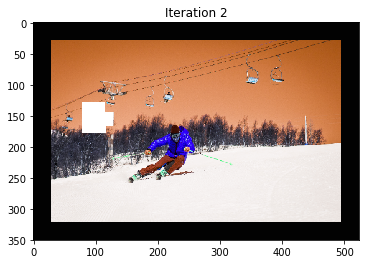

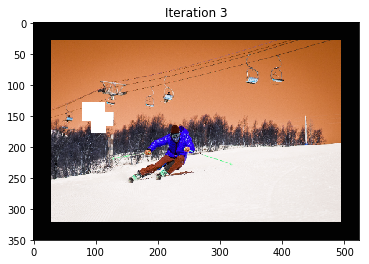

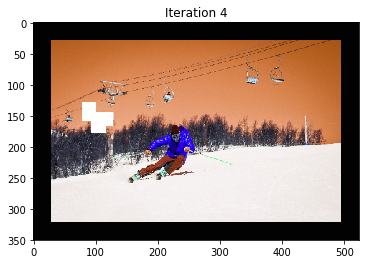

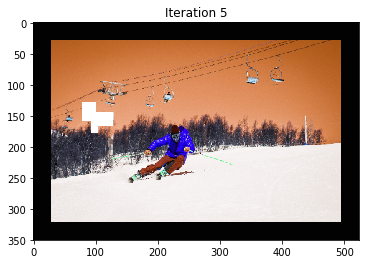

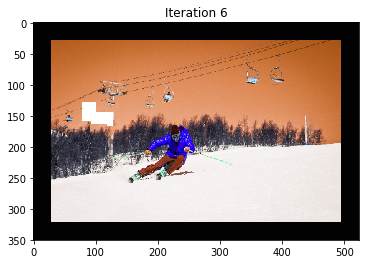

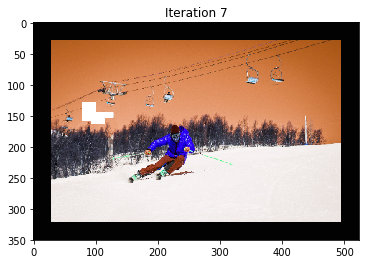

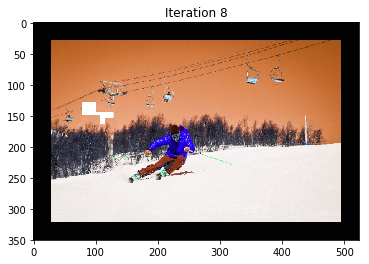

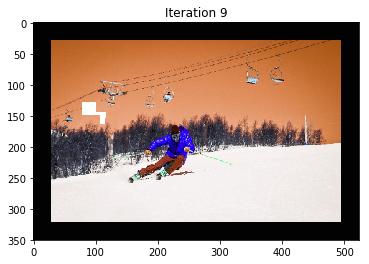

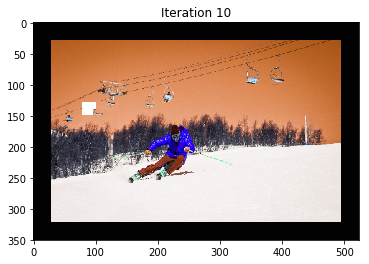

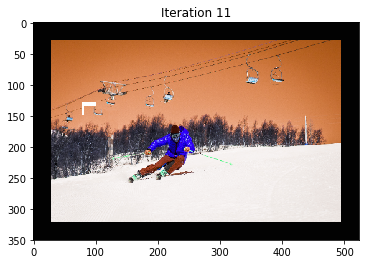

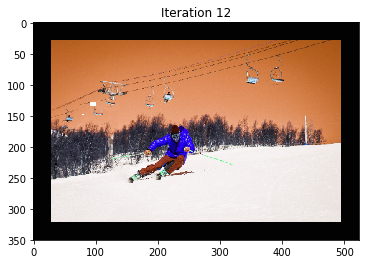

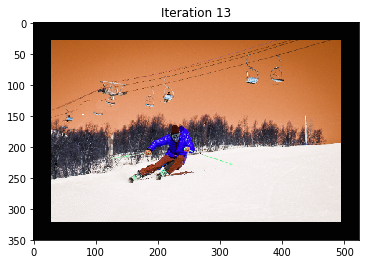

Done in 169.805000067 seconds


In [8]:
#Main loop to fill a first time all holes

#Initialisation
time_init = time.time()
contours = measure.find_contours(marged_img[:,:,0], 0.8)
criteria, contour = find_good_contour(contours, marged_img)
nb_iter = 0
cut_edges = {}

while criteria:
    
    if nb_iter%1== 0:
        plt.imshow(marged_img.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("Iteration " + str(nb_iter))
        plt.show()
    else:
        print("Iteration " + str(nb_iter))
    nb_iter += 1
    
    #Choose of psy
    psi = np.random.randint(psi_min, psi_max) / 2 * 2 + 1
    
    if False:
        print("psi = %s"%psi)
        
    #Define the contour as tuple
    omega=[(i[0], i[1]) for i in contour]
    
    #Create confidence coefficient for each point
    confidence_vector = [confidence_coefficient(confidence, pt, psi=psi) for pt in omega][1:-1]

    #Compute isophote for each point
    isophote_vector = get_isophote(omega, marged_img)[1:-1]

    #Compute the normal of the border vector for each point
    normal_vector = gen_normal_vector(omega)

    #Compute de data term for each point
    data_vector = gen_data_vector(normal_vector, isophote_vector, alpha=10.)

    #Compute the priority term for each term
    priority_vector = [data_vector[i] * confidence_vector[i] for i in range(len(data_vector))]
    
    #Find the point with the highest priority
    m = max(priority_vector)
    indices = [ i for i,j in enumerate(priority_vector) if j==m]
    indice = indices[len(indices)/2]
    patch_x, patch_y = omega[indice+1]
    
    patch_x = int(patch_x + 0.5)
    patch_y = int(patch_y + 0.5)
    
    if False:
        print("Confidence "+str(confidence_vector[indice]) )
        print("Data "+str(data_vector[indice]))
        print("Priority "+str(priority_vector[indice]))
    
    #create the patch to find
    patch = marged_img[np.int(patch_x - psi/2): np.int(patch_x + psi/2+1), np.int(patch_y - psi/2): np.int(patch_y + psi/2+1)]
    
    if False:
        plt.imshow(patch.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("patch " + str(nb_iter))
        plt.show()
    
    #Compute the area to compare between the previous patch and the area on the picture
    is_compared = marged_img[np.int(patch_x - psi/2): np.int(patch_x + psi/2+1), np.int(patch_y - psi/2): np.int(patch_y + psi/2+1)]!=-1
    
    #Find the best match
    if multi_processing:
        result_x, result_y, result_r = findbestmatchmultiprocess(patch, marged_img, is_compared, patch_x, patch_y, psi=psi)
    else:
        result_x, result_y, result_r = findbestmatch(patch, marged_img, is_compared, patch_x, patch_y, psi=psi)
    
    #create the patch to apply
    true_patch = marged_img[result_x - psi/2: result_x + psi/2+1, result_y - psi/2: result_y + psi/2+1].copy()
    true_patch = np.rot90(true_patch, result_r)
    enlarged_true_patch = marged_img[result_x - psi/2-1: result_x + psi/2+2,
                                        result_y - psi/2-1: result_y + psi/2+2].copy()
    enlarged_true_patch = np.rot90(enlarged_true_patch, result_r)
    
    #Create the graph associated
    G = create_graph(marged_img, (patch_x, patch_y), enlarged_true_patch, cut_edges, psi=psi)
    sets = (nx.minimum_cut(G, 'old', 'new', capacity="weight"))
    
    #Compute the two separated sets 
    if 'old' in sets[1][0]:
        set_old = sets[1][0]
        set_new = sets[1][1]
    else:
        set_old = sets[1][1]
        set_new = sets[1][0]
        
    #Find cut edges    
    cut_edges, just_cut_edges = find_cut_edges(G, set_old, cut_edges)
    
    
    cut_edges = update_cut_edges(cut_edges, set_new)
    
    if False:
        plt.imshow(true_patch.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("true_patch " + str(nb_iter))
        plt.show()
    
    #Modify the true patch
    applied_patch = blur_mix(marged_img, true_patch, enlarged_true_patch, set_old, just_cut_edges, patch_x, patch_y, psi)
    #applied_patch = clean_mix(patch, true_patch, set_old, patch_x, patch_y, psi)
                
    
    if False:
        plt.imshow(applied_patch.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("applied_patch " + str(nb_iter))
        plt.show()
        
    if False:
        plt.imshow(applied_patch - true_patch, norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("applied_patch " + str(nb_iter))
        plt.show()
    
    #Apply the patch
    marged_img[np.int(patch_x - psi/2 + 0.5): np.int(patch_x + psi/2+1 + 0.5), 
               np.int(patch_y - psi/2 + 0.5): np.int(patch_y + psi/2+1 + 0.5)] = applied_patch
        
    #Update the condidence matrix, the contour and the looping criteria
    m = confidence_vector[indice]
    confidence[np.int(patch_x - psi/2): np.int(patch_x + psi/2+1), np.int(patch_y - psi/2): np.int(patch_y + psi/2+1)]=m
    contours = measure.find_contours(marged_img[:, :, 0], 0.8)
    criteria, contour = find_good_contour(contours, marged_img)
    
time_taken = time.time() - time_init    
print("Done in %s seconds"%time_taken)

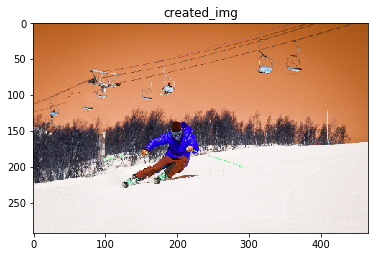

The dim of the image is (350L, 524L, 3L)


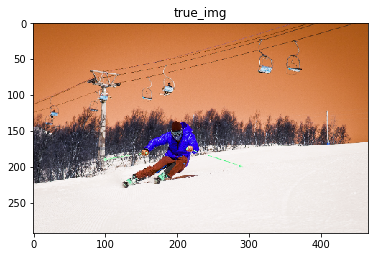

The dim of the image is (350L, 524L, 3L)


In [9]:
#Print the result
result = marged_img[psi_max:-psi_max, psi_max:-psi_max].copy().astype(np.uint8)
plt.imshow(result)
plt.title("created_img")
plt.show()
print 'The dim of the image is ' + str(marged_img.shape)
plt.imshow(img)
plt.title("true_img")
plt.show()
print 'The dim of the image is ' + str(marged_img.shape)

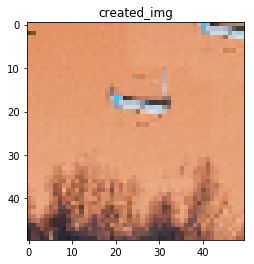

The dim of the image is (350L, 524L, 3L)


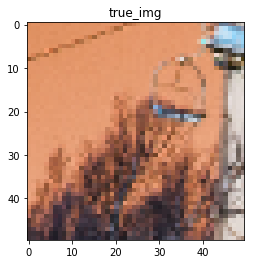

The dim of the image is (292L, 466L, 3L)


In [10]:
#Print the patched result
result_patch_marged = marged_img[hole_left_marged_x:hole_right_marged_x, hole_top_marged_y:hole_bottom_marged_y].copy().astype(np.uint8)
plt.imshow(result_patch_marged)
plt.title("created_patch")
plt.show()
print 'The dim of the image is ' + str(result_patch_marged.shape)
original_patch = img[hole_left_corner_original_x:hole_left_corner_original_x+hole_width, hole_left_corner_original_y:hole_left_corner_original_y+hole_height]
plt.imshow(original_patch)
plt.title("true_img")
plt.show()
print 'The dim of the image is ' + str(original_patch.shape)